# CENSO COMUNIDAD NEGRA ORIKA
## Actualización Censo Mayo 2021
### Isla Grande, PNN Corales del Rosario - Cartagena de Indias, Colombia
La comunidad requiere procesar los datos de la actualización del censo, para generar un arcgivo Excel entregable a entidades públicas y privadas.<br>
<font size="1"><i>12 de agosto de 2021.</i></font>

In [1]:
#Módulos
import pandas as pd
import numpy as np
import geopandas as gp
from shapely.geometry import Point
import requests
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Crear Dataframe con los datos del censo

df_personas = pd.read_csv('censoactualizado.csv', dtype={'edad': np.float64}, decimal=',', na_values=['N/A'])

## Advertencias
El método de levantamiento de datos permitió la captura no homogenea de datos para ciertas variables.  Al parecer el proceso fue manual usando formularios diligenciados a mano, por lo que los valores de las variables difieren en su formato, como por ejemplo: a) combinaciones entre formato de texto y numérico; b) fechas en formato DD/MM/AAAA y MM/DD/AAAA; c) errores ortográficos o; d) valores distintos para un mismo concepto.  El archivo original en formato Excel tiene las siguientes advertencias:

* **Fecha de nacimiento:** Contiene valores de formatos de fecha distintos e incluso texto, algunos campos están el el formato Europeo de día/mes/año (DD/MM/AAAA, por ejemplo: '29/09/1985') y otros en el formato anglosajón de mes/día/año (MM/DD/AAAA, por ejemplo: '9/30/2013') y otros solo contienen el año (por ejemplo: '1941','1942', '1950', '1952', '1954', '1955').  Mezcla con valor tipo texto: 'Confirmar'.  6 registros no contienen datos, están vacíos (NaN).
* **No. Documento:** Contiene valores en texto 'Confirmar' y 'cc: 1.047.370.928'; siendo un campo numérico tipo entero.  32 registros vacíos (NaN).
* **PARENTESCO:** Contiene los siguientes valores en texto: 'Amigo familia', 'Hermano', 'hermana', 'hermano', 'otro', 'primo', 'sobrina', 'sobrino' y 'suegra'.  2 registros no contienen datos, están vacíos (NaN).  Es un campo numérico tipo entero.  El comentario de la casilla de encabezado en Excel, describe los posibles valores de acuerdo a esta lista: Jefe de la Familia: 1; Esposo/a : 2; Hijo : 3; Hijastro: 4; Yerno o nuera: 5; Cuñado/a : 6; Nieto/a :7; Padre o Madre: 8; Padrasto o Madrastra:9; Abuelos: 10; Suegros:11; Hermano 12; Hermanastros: 13; Otros: 14. 
* **EDAD (Años):** Las edades en meses las determina con los siguientes valores de texto: '10 meses', '2 mes', '4 meses', '5 meses' y '7 meses'.  2 registros no contienen datos, están vacíos (NaN).  Es un campo numérico tipo flotante o decimal.
* **SEXO:**  Contiene registros con un caracter de espacio luego de la letra 'M '.  Es una variable dicótoma o buleana.
* **Sector :**  El conjunto de valores de los nombres de los sectores no es homogeneo, por ejemplo: 'EL MOCHO'y 'El Mocho' o 'EL Silencio' y 'El silencio'.  Contiene valores de subsectores, por ejemplo: 'Palmar', 'Risa' y  'caño raton' son subsectores que hacen parte de 'Guinda Mono'.  1 registro no contienen datos, está vacío (NaN).  Es una variable de tipo categoría.
* **N. Casa:** Columna sin datos (NaN).
* **REF. Vivienda:** 2 registros no contienen datos, están vacíos (NaN).
* **Primaria:** Contiene tres valores distintos 'X', 'XX' y 'x'.  Es una variable dicótoma o buleana.
* **Secundaria:** Contiene dos valores distintos 'X', y 'x'.  Es una variable dicótoma o buleana.
* **Otros Est. Cual:**  El conjunto de valores de los nombres de otros estudios no es homogeneo, por ejemplo: 'TECNOL', 'TECNOLOG', 'Tecnologa' o 'Tecnologia'.  Contiene valores que no corresponden a niveles de educación: 'Auxiliar', 'GUARDER'.  Es una variable de tipo categoría.
* **Ocupación:** Valores no homogéneos para un mismo concepto, por ejemplo: 'celador', 'celadora', 'cuido' y 'Seguridad'.  Otros ambiguos como: 'trabajador'. 94 registros no contienen datos, están vacíos (NaN).  Es una variable de tipo categoría.
* **EPS:** Valores no homogéneos para un mismo concepto.
* **Tipo   Tenencia:** Valores no homogéneos para un mismo y diferente concepto, mezcla entre propiedad, uso y actividad del tenedor o habitante de la vivienda o terreno.
* **Tiempo de  Residencia :** Contiene valores de formatos de fecha distintos e incluso texto, algunos campos están el el formato Europeo de día/mes/año (DD/MM/AAAA, por ejemplo: '15/04/2016')otros solo contienen el año (por ejemplo: '1943', '1955', '1957', '1959', '1961').  Mezcla con valor tipo texto, por ejemplo:'1 6añoS', '1 AÑO', '1 año', '1 años' o '10 años'.  3 registros no contienen datos, están vacíos (NaN).  Es una variable tipo fecha.
* **Procedencia:** Valores no homogéneos y que no siguen un concepto geográfico unificado.  Hay mezcla de municipios, departamentos y países.
* **Discapasitados:**  Valores no homogeneos 'N', 'N o', 'NO', 'No', 'Si', 'no' y 'si'.  Es una variable dicótoma o buleana.  El nombre de la variable tiene error ortográfico.
* **Telefono:** OK. Es una variable de tipo entero.
* **Nativo/ foráneo :**  Valores no homogeneos 'F', 'N', 'N  ' y 'f'.  Es una variable dicótoma o buleana. 5 registros no contienen datos, están vacíos (NaN). Debería ser una condición basada en los valores de las variables de familia y tiempo de residencia en la isla.
* **Residente   si/no:**  Valores no homogeneos No', 'SI', 'Si', 'no' y 'si'.  Es una variable dicótoma o buleana. 4 registros no contienen datos, están vacíos (NaN)'
* **Mujer cabeza de hogar:** Valores no homogeneos 'NO', 'No', 'SI', 'Si' y 'si'.  Es una variable dicótoma o buleana.  Posible duplicidad de conceptos, se podría inferir si es _Mujer Cabeza de Hogar_ si la persona censada es de **Sexo** _Femenino_ y el **Parentesco** es _Jefe de la Familia_.

## Arreglo de datos
El siguiente _script_ corrige las advertencias encontradas y por último exporta a Excel los datos del censo.

In [3]:
## CORREGIR FECHA DE NACIMIENTO (por hacer)
# Formato por defecto es dd/mm/aaaa; entonces:
# 1) sí mm > 12 --> arreglar el string para intercambiar mm por dd.
# 2) Si tiene solo año agregar dd{01}/mm{01}/year
# 3) Si tiene el texto 'Confirmar' remplazar por NaN.

## CORREGIR NO.DOCUMENTO

df_personas['No. Documento'] = df_personas['No. Documento'].astype(str).map(lambda x: x.replace('Confirmar', '').\
                                                            replace('.', '').replace('cc: ', '').\
                                                            replace('nan', ''))

# ¿How to apply a dict in replace()?
#df_personas['identidad'] = df_personas['No. Documento'].astype(str).map(lambda x: x.replace({'Confirmar':'', \
#                                                        '.':'', 'cc: ':'', 'nan':''}))

## CORREGIR PARENTESCO

def parentesco(x):
    if x=='1':
        return 'Jefe de la Familia'
    if x=='2':
        return 'Esposo/a'
    if x=='3':
        return 'Hijo/a'
    if x=='4':
        return 'Hijastro/a'
    if x=='5':
        return 'Yerno o nuera'
    if x=='6':
        return 'Cuñado/a'
    if x=='7':
        return 'Nieto/a'
    if x=='8':
        return 'Padre o Madre'
    if x=='11' or x=='suegra':
        return 'Suegro/a'
    if x=='12' or x=='hermano' or x=='Hermano' or x=='hermana':
        return 'Hermano/a'
    if x=='14' or x=='0' or x=='otro' or x=='Amigo familia' or x=='primo' or x=='sobrino' or x=='sobrina':
        return 'Otros'
    
df_personas['PARENTESCO'] = df_personas['PARENTESCO'].apply(parentesco)
df_personas['PARENTESCO'] = df_personas['PARENTESCO'].astype('category')


# CORREGIR VARIABLE DE EDAD

edad_meses_index = df_personas.loc[df_personas['EDAD (Años)']\
                              .str.contains(pat='mes', regex=False, na=False)]\
                              .index.to_list()

for i in edad_meses_index:
    df_personas.iat[i, 5] = float(df_personas.iat[i, 5].replace('meses', '').replace('mes', '').strip())
    df_personas.iat[i, 5] = df_personas.iat[i, 5]/12

df_personas['EDAD (Años)'] = df_personas['EDAD (Años)'].astype(np.float64)

# ELIMINAR ESPACIOS EN LA VARIABLE SEXO
df_personas.SEXO = df_personas.SEXO.str.strip()

## UNIFICAR NOMBRES DE LOS SECTORES DE LA ISLA

def sector(x):
    if x=='El Mocho' or x=='EL MOCHO':
        return 'El Mocho'
    if x=='Las Flores' or x=='Las flores':
        return 'Yazmin'
    if x=='El silencio' or x=='EL Silencio':
        return 'El Silencio'
    if x=='guinda' or x=='Risa' or x=='Palmar' or x=='caño raton' or x=='Guinda':
        return 'Guinda Mono'
    if x=='Isleta':
        return 'Isleta'
    if x=='Petare' or x=='petare':
        return 'Petares'
    if x=='La Punta':
        return 'La Punta'

df_personas['Sector'] = df_personas['Sector '].apply(sector)
df_personas['Sector'] = df_personas['Sector'].astype('category')
df_personas.drop(['Sector ', 'N. Casa'], axis=1, inplace=True)

## CREAR UNA COLUMNA UNIFICADA PARA EL NIVEL DE EDUCACIÓN

def primaria(x):
    if x=='X' or x=='XX' or x=='x':
        return 'Primaria'
    
df_personas['Primaria'] = df_personas['Primaria'].apply(primaria)

def secundaria(x):
    if x=='X' or x=='x':
        return 'Secundaria'
    
df_personas['Secundaria'] = df_personas['Secundaria'].apply(secundaria)

def superior(x):
    if x=='univ com' or x=='Univ' or x=='Universit' or x=='universit' or x=='Universidad' \
        or x=='UNIVERSIT' or x=='universitar' or x=='UNIVERS' or x=='universidad':
        return 'universitario-completo'
    if x=='Univ Inc':
        return 'universitario-incompleto'
    if x=='Tecnico' or x=='tecnico' or x=='TECNICO' or x=='Auxiliar':
        return 'tecnico-completo'
    if x=='tecnologo' or x=='Tecnologa' or x=='tecnologa' or x=='Tecnologo' or x=='TECNOL' or x=='TECNOLOG' \
        or x=='tecnolog' or x=='Tecnologia':
        return 'tecnologo-completo'
    if x=='postgrad' or x=='Posgrado':
        return 'postgrado'
    if x=='GUARDER':
        return ''

df_personas['Otros Est. Cual'] = df_personas['Otros Est. Cual'].apply(superior)

df_personas['Primaria'] = df_personas['Primaria'].astype(str)
df_personas['Secundaria'] = df_personas['Secundaria'].astype(str)
df_personas['Otros Est. Cual'] = df_personas['Otros Est. Cual'].astype(str)

df_personas['Nivel-educativo'] = df_personas[['Primaria', 'Secundaria', 'Otros Est. Cual']].agg(''.join, axis=1)
df_personas['Nivel-educativo'] = df_personas['Nivel-educativo'].str.replace('None', '', regex=False)
df_personas['Nivel-educativo'] = df_personas['Nivel-educativo'].str.replace('nan', '', regex=False)
df_personas['Nivel-educativo'] = df_personas['Nivel-educativo'].astype('category')

df_personas.drop(['Primaria', 'Secundaria', 'Otros Est. Cual'], axis=1, inplace=True)

## CORREGIR VALORES EN OCUPACIÓN (por hacer)

'''
df_personas['ocupación'] = df_personas['ocupación'].str.lower()

df.replace({'a' : {'Medium':2, 'Small':1, 'High':3 }}, regex=True)


La Dirección de Impuestos y Aduanas Nacionales (DIAN) expidió la Resolución
000114 del 21 de diciembre de 2020, por la cual adopta la Clasificación de
Actividades Económicas (CIIU Rev. 4 A

['agricultor', 'albañil', 'ama de casa', 'artesana', 'aseo veolia',
       'auxiliar enfermer', 'ayudante lancha', 'ayudante obra',
       'bailarina', 'bartender', 'cajera', 'camarera', 'cantinero',
       'celador', 'celadora', 'cocinera', 'comercio', 'comunitario',
       'construccion', 'coord alimentos', 'cuido', 'ecohotel',
       'empleado veolia', 'estadero', 'estudiante', 'estuduante',
       'gaitero', 'guarderia', 'hogar comun', 'independiente',
       'jefe de cocina', 'marinero', 'masajista', 'mesera', 'musico',
       'negocio prop', 'oficios  varios', 'oficios domesticos',
       'oficios varios', 'oficios varios ', 'otra', 'otros', 'paator',
       'pastor', 'pensionado', 'pescador', 'piloto', 'pizzero',
       'profesora', 'salubrista', 'seguridad', 'servicio comunitario',
       'servicio naval', 'servicio turisitico', 'servicio turistico',
       'servicios turisiticos', 'servicios turistico',
       'servicios turisticos', 'tecnologo', 'trabajador', 'vigilante',
       nan]
'''

## Adicionar columna de Grupos Etarios
# Con base en:
# https://www.minsalud.gov.co/proteccionsocial/Paginas/cicloVida.aspx
# primera infancia (0-5 años), infancia (6 - 11 años), adolescencia (12-18 años),
# juventud (14 - 26 años), adultez (27 - 59 años) y vejez (60 años y más)

df_personas['Grupo_etario'] = pd.cut(df_personas['EDAD (Años)'], bins=[0, 5, 11, 26, 59, 110],
                            labels=['Primera Infancia (0-5)', 'Infancia (6-11)',
                                    'Adolecentes y Jóvenes (12-26)', 'Adultos (27-59)', 'Mayores (+60)'])

In [4]:
## Exportar a Excel
df_personas.to_excel("censo-orika-2021.xlsx", sheet_name='censo-orika-2021', index=False, freeze_panes=(1,0))

## Análisis y visualización de datos

### Total de la población
El censo determino un total de la población de 981 personas, 15 persona más que en 2019, cuando el censo arrojó un total de 966, es decir, un incremento del 1,55%.

In [5]:
print('Total de Habitantes: ' + str(len(df_personas)))

Total de Habitantes: 981


### Edades
Es una población joven, el mayor grupo de edades se encuentra entre los 15 y 24 años.

#### Piramide poblacional ONU
La siguiente es la pirámide poblacional de acuerdo a los grupos etarios o segmentos de población designados por la Organización Mundial de la Salud (OMS).

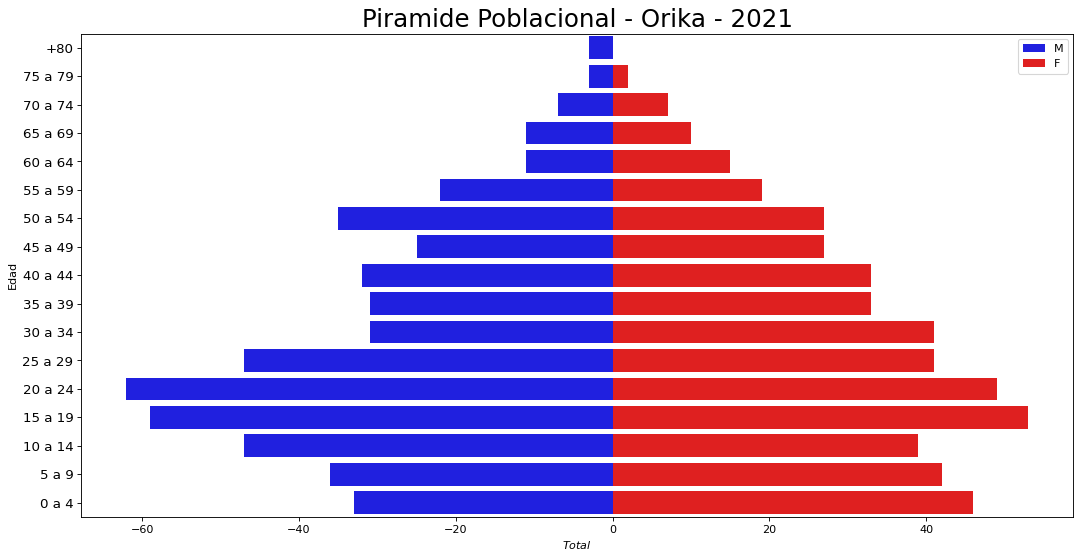

In [6]:
# Adicionar columna de segmentos de población OMS
df_personas['poblacion_oms'] = pd.cut(df_personas['EDAD (Años)'],\
                                      bins=[0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54,
                                            59, 64, 69, 74, 79, 100],
                                labels=['0 a 4', '5 a 9', '10 a 14', '15 a 19', '20 a 24', '25 a 29',
                                        '30 a 34', '35 a 39', '40 a 44', '45 a 49', '50 a 54', '55 a 59',
                                        '60 a 64', '65 a 69', '70 a 74', '75 a 79', '+80'])
# Create dataset
grupo_m = df_personas[df_personas['SEXO']=='M'].groupby(['poblacion_oms'])['poblacion_oms'].count().to_frame()
grupo_m['SEXO'] = ['M'] * len(grupo_m)
grupo_f = df_personas[df_personas['SEXO']=='F'].groupby(['poblacion_oms'])['poblacion_oms'].count().to_frame()
grupo_f['SEXO'] = ['F'] * len(grupo_f)
piramide = pd.concat([grupo_m, grupo_f])
piramide.loc[piramide.SEXO != 'F', 'poblacion_oms'] *= -1
piramide['grupos'] = piramide.index
piramide.columns = ['total', 'sexo', 'grupo']
piramide.reset_index(drop=True, inplace=True)
piramide

# Read data
df = piramide

# Draw Plot
plt.figure(figsize=(16,8), dpi= 80)
group_col = 'sexo'
order_of_bars = df.grupo.unique()[::-1]
colors = [plt.cm.bwr(i/float(len(df[group_col].unique())-1)) for i in range(len(df[group_col].unique()))]

for c, group in zip(colors, df[group_col].unique()):
    sns.barplot(x='total', y='grupo', data=df.loc[df[group_col]==group, :],\
                order=order_of_bars, color=c, label=group)

# Decorations    
plt.xlabel("$Total$")
plt.ylabel("Edad")
plt.yticks(fontsize=12)
plt.title("Piramide Poblacional - Orika - 2021", fontsize=22)
plt.legend()
plt.show()

## Source:
#https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#29.-Population-Pyramid

In [7]:
piramide2 = pd.concat([grupo_m, grupo_f], axis=1)
piramide2.columns = ['Masculino', 'M', 'Femenino', 'F']
piramide2.drop(['M', 'F'], axis=1, inplace=True)
piramide2['Total'] = piramide2['Masculino'] + piramide2['Femenino']
piramide2.loc['Total']= piramide2.sum()
piramide2

# Advertencia: el total de personas es 479, debido a dos registros vacíos en la columna 'Edad (Años)'.

,Masculino,Femenino,Total
poblacion_oms,,,
0 a 4,33,46,79
5 a 9,36,42,78
10 a 14,47,39,86
15 a 19,59,53,112
20 a 24,62,49,111
25 a 29,47,41,88
30 a 34,31,41,72
35 a 39,31,33,64
40 a 44,32,33,65


#### Piramide poblacional Grupos Etarios - Colombia
La siguiente es la pirámide poblacional con referencia a los grupos etarios sugeridos por el Ministerio de Salud de Colombia.

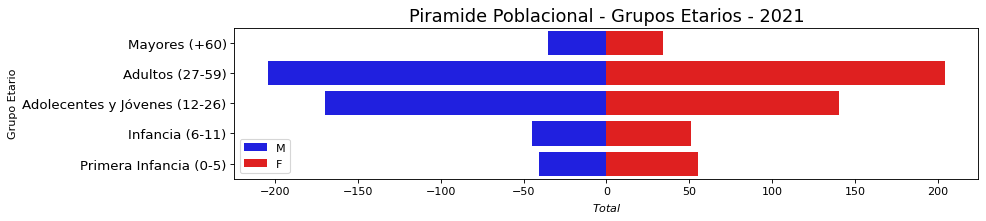

In [8]:
# Tabla de grupos etarios

grupo_m = df_personas[df_personas['SEXO']=='M'].groupby(['Grupo_etario'])['Grupo_etario'].count().to_frame()
grupo_m['SEXO'] = ['M'] * len(grupo_m)
grupo_f = df_personas[df_personas['SEXO']=='F'].groupby(['Grupo_etario'])['Grupo_etario'].count().to_frame()
grupo_f['SEXO'] = ['F'] * len(grupo_f)
piramide = pd.concat([grupo_m, grupo_f])
piramide.loc[piramide.SEXO != 'F', 'Grupo_etario'] *= -1
piramide['grupos'] = piramide.index
piramide.columns = ['total', 'sexo', 'grupo']
piramide.reset_index(drop=True, inplace=True)
piramide

# Read data
df = piramide

# Draw Plot
plt.figure(figsize=(12,2.5), dpi= 80)
group_col = 'sexo'
order_of_bars = df.grupo.unique()[::-1]
colors = [plt.cm.bwr(i/float(len(df[group_col].unique())-1)) for i in range(len(df[group_col].unique()))]

for c, group in zip(colors, df[group_col].unique()):
    sns.barplot(x='total', y='grupo', data=df.loc[df[group_col]==group, :],\
                order=order_of_bars, color=c, label=group)

# Decorations    
plt.xlabel("$Total$")
plt.ylabel("Grupo Etario")
plt.yticks(fontsize=12)
plt.title("Piramide Poblacional - Grupos Etarios - 2021", fontsize=16)
plt.legend()
plt.show()

In [9]:
piramide2 = pd.concat([grupo_m, grupo_f], axis=1)
piramide2.columns = ['Masculino', 'M', 'Femenino', 'F']
piramide2.drop(['M', 'F'], axis=1, inplace=True)
piramide2['Total'] = piramide2['Masculino'] + piramide2['Femenino']
piramide2.loc['Total']= piramide2.sum()
piramide2

# Advertencia: el total de personas es 479, debido a dos registros vacíos en la columna 'Edad (Años)'.

,Masculino,Femenino,Total
Grupo_etario,,,
Primera Infancia (0-5),41,55,96
Infancia (6-11),45,51,96
Adolecentes y Jóvenes (12-26),170,140,310
Adultos (27-59),204,204,408
Mayores (+60),35,34,69
Total,495,484,979


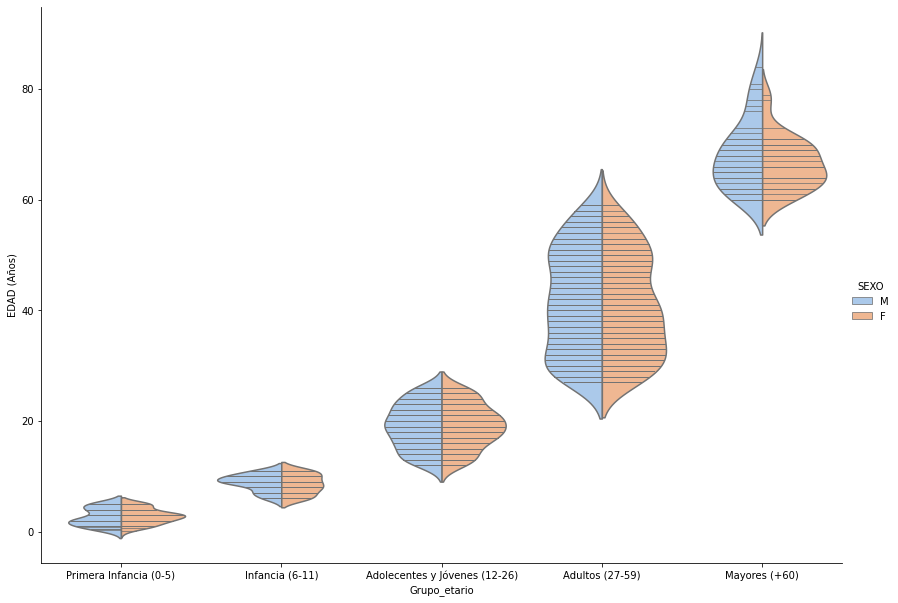

In [18]:
sns.catplot(x="Grupo_etario", y="EDAD (Años)", hue="SEXO",
            kind="violin", split=True, data=df_personas, 
            height=8.27, aspect=11.7/8.27, inner="stick", palette='pastel');

#### Niveles de educación por grupos etarios y sexo
Los siguientes gráficos representan los niveles de eduación de la población respecto a su edad y sexo.  Las mujeres tienden en mayor proporción a continuar con sus estudios superiores (universitarios) que los hombres.

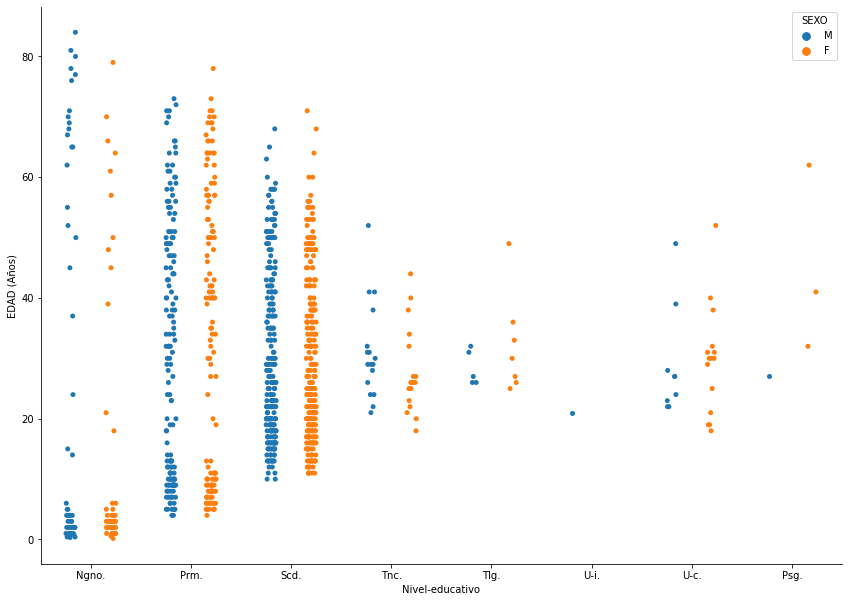

In [30]:
sns.catplot(x='Nivel-educativo', y='EDAD (Años)', hue='SEXO', legend_out=False, legend=True, \
            order=['', 'Primaria', 'Secundaria', 'tecnico-completo', \
                   'tecnologo-completo', 'universitario-incompleto', 'universitario-completo', 'postgrado'],
        kind="strip", dodge=True, data=df_personas, height=8.27, aspect=11.7/8.27).set_xticklabels(['Ngno.', \
                    'Prm.', 'Scd.', 'Tnc.', 'Tlg.','U-i.', 'U-c.', 'Psg.'])


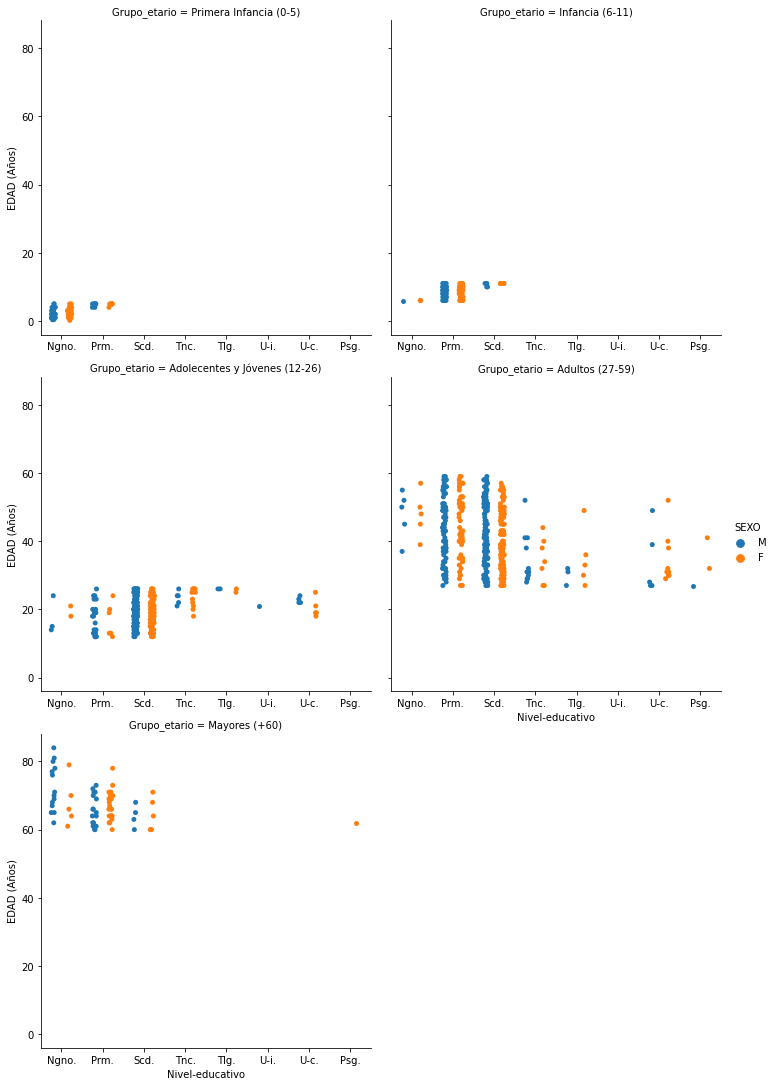

In [48]:
sns.catplot(x='Nivel-educativo', y='EDAD (Años)', hue='SEXO', dodge=True, sharex=False, \
            order=['', 'Primaria', 'Secundaria', 'tecnico-completo', \
                   'tecnologo-completo', 'universitario-incompleto', 'universitario-completo', 'postgrado'],
        col='Grupo_etario', col_wrap=2, kind="strip", data=df_personas).set_xticklabels(['Ngno.', \
                    'Prm.', 'Scd.', 'Tnc.', 'Tlg.','U-i.', 'U-c.', 'Psg.'])

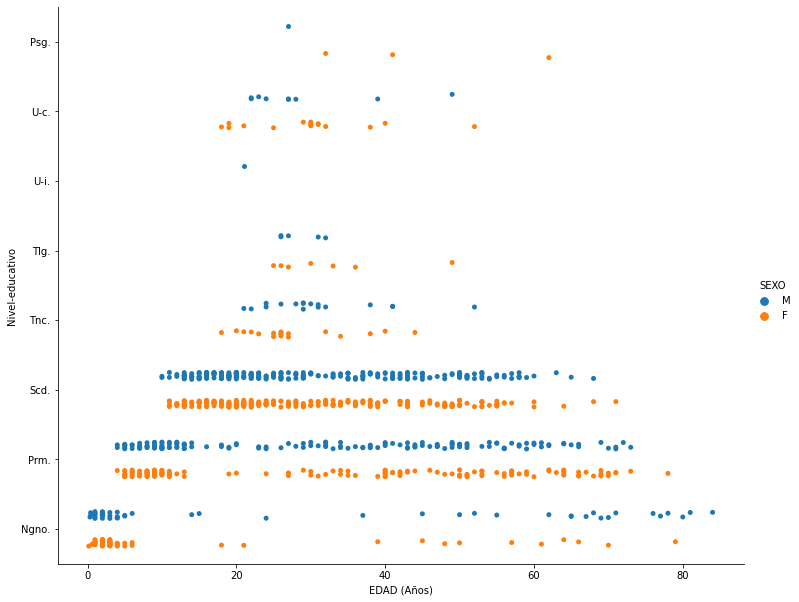

In [52]:
sns.catplot(y='Nivel-educativo', x='EDAD (Años)', hue='SEXO', legend_out=True, legend=True, \
            order=['postgrado', 'universitario-completo', 'universitario-incompleto', 'tecnologo-completo', \
                   'tecnico-completo', 'Secundaria', 'Primaria', ''],
        kind="strip", dodge=True, data=df_personas, height=8.27, aspect=11.7/8.27).set_yticklabels(['Psg.', \
                    'U-c.', 'U-i.', 'Tlg.', 'Tnc.', 'Scd.', 'Prm.', 'Ngno.'])


- - -

> Este es un trabajo en marcha y exploratorio, abierto a comentarios, críticas y aportes.

- - -